## 영화리뷰 텍스트 감성분석하기

### 학습목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성분류 실습을 진행한다.

## 텍스트 데이터의 특징 (1) 텍스트를 숫자로 표현하는 방법

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 처리해야 할 문장을 파이썬 리스트에 옮겨담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [3]:
# 우리의 텍스트 데이터로부터 사전을 만들기 위해 모든 문장을 단어 단위로 쪼갠 후에 파이썬 딕셔너리(dict) 자료구조로 표현해 보겠습니다.

index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [4]:
# 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조로 만들기
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [5]:
# 딕셔너리는 단어를 주면 그 단어의 인덱스를 반환하는 방식으로 사용
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [6]:
# 텍스트 데이터를 숫자로 바꿔 표현해 봅시다.
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [7]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [8]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [9]:
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


## 텍스트 데이터의 특징 (2) Embedding 레이어의 등장

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)


vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있습니다.

# Tensorflow에서는 keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 
# 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.
# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.02884325  0.0323563  -0.01087039 -0.0218204 ]
  [-0.00959275 -0.02911035  0.0483732   0.03494759]
  [ 0.01841403  0.03676256 -0.02922511 -0.00813949]
  [-0.03681504 -0.01195597 -0.04270029  0.00373822]
  [-0.02058859 -0.04647559  0.00645499 -0.03575699]]

 [[ 0.02884325  0.0323563  -0.01087039 -0.0218204 ]
  [-0.00959275 -0.02911035  0.0483732   0.03494759]
  [ 0.0388009  -0.02245009 -0.03801974 -0.02875713]
  [ 0.02862697 -0.00169996 -0.00982492 -0.03730832]
  [-0.02058859 -0.04647559  0.00645499 -0.03575699]]

 [[ 0.02884325  0.0323563  -0.01087039 -0.0218204 ]
  [ 0.03206691 -0.00120597 -0.00111275  0.00877213]
  [-0.00959275 -0.02911035  0.0483732   0.03494759]
  [ 0.01841403  0.03676256 -0.02922511 -0.00813949]
  [ 0.04169781  0.01735575  0.0236916  -0.01884592]]], shape=(3, 5, 4), dtype=float32)


## 시퀀스 데이터를 다루는 RNN

In [11]:
# RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제코드
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


## 꼭 RNN이어야 할까?

텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)을 사용할 수도 있습니다. 우리는 이미지 분류기를 구현하면서 2-D CNN을 이미 사용해 본 바 있습니다. 이미지는 시퀀스 데이터가 아닙니다. 이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용됩니다. 그러므로 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됩니다. 이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여줍니다. 그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습속도도 훨씬 빠르게 진행된다는 장점이 있습니다.


In [12]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
# 아주 간단히는 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있습니다. 
# 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 
# 의외로 성능이 잘 나올 수도 있습니다.

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## IMDB 영화리뷰 감성분석 (1) IMDB 데이터셋 분석

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [15]:
# imdb.load_data() 호출시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 
# 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됩니다.

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [16]:
# 텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드받았음을 확인할 수 있습니다.
# 이미 텍스트가 encode되었으므로 IMDB 데이터셋에는 encode에 사용한 딕셔너리까지 함께 제공합니다.

word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [17]:
# MDB 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 아래와 같이 보정되어야 합니다. 
# 아래 내용은 Tensorflow 튜토리얼의 가이드를 반영하여 작성하였습니다.
# word_to_index는 IMDB 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어 있습니다.

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [18]:
# 다운받은 데이터셋이 확인되었습니다. 마지막으로, encode된 텍스트가 정상적으로 decode되는지 확인해 보겠습니다.

print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [19]:
# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안됩니다.
# 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됩니다. 
# 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋습니다.

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [20]:
# 위의 경우에는 maxlen=580이 됩니다.
# 또 한가지 유의해야 하는 것은 padding 방식을 문장 뒷쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 
# RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점입니다.
# 두 가지 방식을 한번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교해 보시기 바랍니다.

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [21]:
# 위의 경우에는 maxlen=580이 됩니다.
# 또 한가지 유의해야 하는 것은 padding 방식을 문장 뒷쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 
# RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점입니다.
# 두 가지 방식을 한번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교해 보시기 바랍니다.

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## IMDB 영화리뷰 감성분석 (2) 딥러닝 모델 설계와 훈련

In [22]:
# RNN 모델을 직접 설계해 보자

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 우리가 사용할 수 있는 모델에는 RNN만 있는 것이 아닙니다. 이전 스텝에서 구현해 본 다양한 모델들이 전부 사용 가능합니다.

# model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 
# 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [24]:
# model 학습을 시작해 봅시다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6911 - accuracy: 0.6443 - val_loss: 0.6869 - val_accuracy: 0.7249
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.6787 - accuracy: 0.7161 - val_loss: 0.6710 - val_accuracy: 0.7237
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.6573 - accuracy: 0.7679 - val_loss: 0.6480 - val_accuracy: 0.7648
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.6265 - accuracy: 0.8076 - val_loss: 0.6160 - val_accuracy: 0.7835
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5850 - accuracy: 0.8263 - val_loss: 0.5755 - val_accuracy: 0.8036
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5352 - accuracy: 0.8409 - val_loss: 0.5308 - val_accuracy: 0.8107
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4823 - accuracy: 0.8524 - val_loss: 0.4877 - val_accuracy: 0.8206
Epoch 8/20
30

In [25]:
# 학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.3619 - accuracy: 0.8426
[0.3618706166744232, 0.8426399827003479]


In [26]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 
# 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


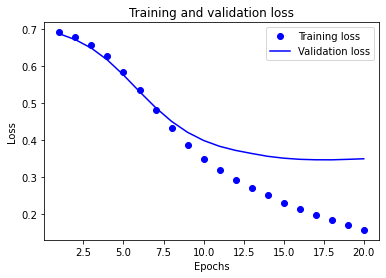

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

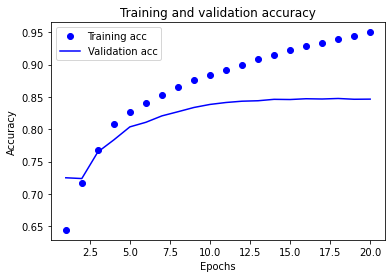

In [28]:
# Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. 
# validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.
# 마찬가지로 Training and validation accuracy를 그려 보아도 유사한 인사이트를 얻을 수 있습니다.

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## IMDB 영화리뷰 감성분석 (3) Word2Vec의 적용

In [29]:
# 워드벡터를 다루는데 유용한 gensim 패키기 설치함
# mkdir -p -~/aiffel/sentimental_classification
!pip install gensim

In [30]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_s

(10000, 16)


In [31]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/naver_movie_review/sentimental_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.02946928, -0.02853395, -0.02435401, -0.04404843, -0.02059644,
       -0.04887279, -0.0268178 , -0.02948667, -0.02386098,  0.0216036 ,
       -0.02874109, -0.02055578, -0.0187801 , -0.02839378,  0.03932932,
       -0.04726087], dtype=float32)

In [33]:
word_vectors.similar_by_word("love")

[('coming', 0.9838578701019287),
 ('negative', 0.9832875728607178),
 ('training', 0.9829071164131165),
 ('art', 0.9824705719947815),
 ('roman', 0.9823288917541504),
 ('disturbing', 0.9815885424613953),
 ('sound', 0.9797816276550293),
 ('passes', 0.9792391061782837),
 ("isn't", 0.9787222743034363),
 ('yes', 0.9783115386962891)]

In [36]:
# Google의 Word2Vec 모델을 가져와 적용해 봅시다.

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/naver_movie_review/sentimental_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [35]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

NameError: name 'word2vec' is not defined

In [37]:
# 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다. 

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [38]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [39]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 23s 762ms/step - loss: 0.6934 - accuracy: 0.5185 - val_loss: 0.6834 - val_accuracy: 0.5618
Epoch 2/20
30/30 [==============================] - 6s 202ms/step - loss: 0.6577 - accuracy: 0.6132 - val_loss: 0.6458 - val_accuracy: 0.6283
Epoch 3/20
30/30 [==============================] - 6s 201ms/step - loss: 0.5562 - accuracy: 0.7363 - val_loss: 0.4925 - val_accuracy: 0.7756
Epoch 4/20
30/30 [==============================] - 6s 202ms/step - loss: 0.3701 - accuracy: 0.8519 - val_loss: 0.4049 - val_accuracy: 0.8141
Epoch 5/20
30/30 [==============================] - 6s 203ms/step - loss: 0.2656 - accuracy: 0.8970 - val_loss: 0.3345 - val_accuracy: 0.8566
Epoch 6/20
30/30 [==============================] - 6s 203ms/step - loss: 0.1915 - accuracy: 0.9323 - val_loss: 0.3292 - val_accuracy: 0.8606
Epoch 7/20
30/30 [==============================] - 6s 202ms/step - loss: 0.1405 - accuracy: 0.9567 - val_loss: 0.3228 - val_accuracy: 0.8679
Epoch

In [40]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 9s - loss: 0.5549 - accuracy: 0.8546
[0.5548879504203796, 0.854640007019043]


## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 1) 데이터 준비와 확인

In [42]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/naver_movie_review/sentimental_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/naver_movie_review/sentimental_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
train_data.shape

(150000, 3)

In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 2) 데이터로더 구성
- tokenizer는 Mecab을 사용
- 불용어도 간단하게 정의 후 전처리에 사용
- word_to_index생성

In [45]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

## index_to_word생성
- word_to_index를 활용해서 새로운 index_to_word생성
- 그외에 인덱스를 입력하면 단어로 리턴해주는 함수, 단어를 입력하면 인덱스로 리턴해주는 함수를 정의

In [46]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [47]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [48]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [49]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [50]:
X_test.shape

(49157, 41)

## 4) 모델구성 및 validation set 구성

파라미터를 고정하여 3가지 모델로 학습
- 1-D CNN
- LSTM
- GlobalMaxPooling1D
이후에 가장 성능이 좋은 모델 선택 후 파라미터 튜닝을 수행

In [51]:
len(X_train)

146182

In [52]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


In [53]:
# 세가지 모델을 평가할 때, 파라미터는 고정으로 사용
vocab_size = len(index_to_word)
word_vector_dim = 300

### 1-D CNN

In [54]:
import os
import tensorflow as tf

# CNN
CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 256)         537856    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9       

### LSTM

In [55]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


### GlobalMaxPooling1D

In [56]:
# GlobalMaxPooling1D

GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


### 3가지 모델을 같은 조건에서 학습 후 결과 확인

In [57]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [58]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results

----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 27s 110ms/step - loss: 0.4035 - accuracy: 0.8085 - val_loss: 0.3278 - val_accuracy: 0.8569
Epoch 2/20
247/247 [==============================] - 9s 36ms/step - loss: 0.2835 - accuracy: 0.8814 - val_loss: 0.3274 - val_accuracy: 0.8611
Epoch 3/20
247/247 [==============================] - 9s 36ms/step - loss: 0.2050 - accuracy: 0.9196 - val_loss: 0.3532 - val_accuracy: 0.8593
Epoch 4/20
247/247 [==============================] - 9s 36ms/step - loss: 0.1239 - accuracy: 0.9552 - val_loss: 0.4333 - val_accuracy: 0.8479
Epoch 5/20
247/247 [==============================] - 9s 36ms/step - loss: 0.0737 - accuracy: 0.9749 - val_loss: 0.5324 - val_accuracy: 0.8504
Epoch 6/20
247/247 [==============================] - 9s 36ms/step - loss: 0.0462 - accuracy: 0.9847 - val_loss: 0.6507 - val_accuracy: 0.8454
Epoch 7/20
247/247 [==============================] - 9s 36ms/step - loss: 0.

Epoch 16/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 0.7456 - val_accuracy: 0.8436
Epoch 17/20
247/247 [==============================] - 7s 29ms/step - loss: 0.0089 - accuracy: 0.9964 - val_loss: 0.7609 - val_accuracy: 0.8425
Epoch 18/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0083 - accuracy: 0.9966 - val_loss: 0.7847 - val_accuracy: 0.8414
Epoch 19/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0080 - accuracy: 0.9968 - val_loss: 0.7954 - val_accuracy: 0.8434
Epoch 20/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0076 - accuracy: 0.9968 - val_loss: 0.8122 - val_accuracy: 0.8418
Start evaluating GMP ...
1537/1537 - 2s - loss: 0.8253 - accuracy: 0.8388


In [59]:
for name, [_, acc] in sorted(model_result.items(), key=lambda x : x[1][1], reverse=True) :
    print(name,'\t',acc)

LSTM 	 0.8527778387069702
CNN 	 0.83941251039505
GMP 	 0.8388022184371948


## 5) 모델 훈련 개시

위의 모델 중에서 LSTM의 성능이 가장 좋았다.
모델을 훈련하기 전에 먼저 성능을 올릴 수 있는 최적의 하이퍼파라미터를 찾아본다.

### 최적의 모델 만들기

- LSTM모델 앞에 CNN을 추가도 해보았고, LSTM을 추가도 해보았다.
- CNN의 경우는 추가를 하면 성능이 더 나빴다.
- LSTM층을 하나 더 추가할 경우 결과는 크게 달라지지 않았지만 학습 곡선이 다르게 나타나는 것을 알 수 있었다.
- 간단하게 LSTM 레이어 하나만을 사용해서 하이퍼파라미터를 튜닝해보도록 하였다.
- word_vector_dim 을 늘려가면서 성능이 점점 더 좋아지는 것을 알 수 있었다.
: 1000
- LSTM 레이어의 벡터 차원수를 기존에 8에서 128까지 늘렸다.
: input dimension이 1000개에 반해 128개의 차원은 여전히 부족하지 않을까?
- Overfitting이 자주 발생하여서 LSTM의 인자로 Dropout도 추가하였다.

In [60]:
word_vector_dim = 1000  # 워드 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# CNN을 추가했을 때
# model.add(keras.layers.Conv1D(8, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D())
# LSTM 레이어를 두개로 학습했을 때
# model.add(keras.layers.LSTM(256, dropout=0.7, return_sequences=True))
model.add(keras.layers.LSTM(128, dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 이진분류

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 1000)        10000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               578048    
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 10,579,089
Trainable params: 10,579,089
Non-trainable params: 0
_________________________________________________________________


이전에 20번 epoch을 돌리는 동안 validation loss값이 오르는 것을 확인할 수 있었다.(Overfitting 발생)

그렇게 때문에 callback의 EarlyStopping을 사용하였고 최적의 모델을 저장하기 위해서 ModelCheckpoint를 사용하였다.

In [61]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

optimizer에서 사용하는 Adam에도 learning rate를 조절해주었다.
이전에 세가지 모델을 학습시켜보았을 때 여러번 학습이 진행되기 전에 Overfitting이 발생하였기 때문에 학습률을 낮추었다. 추가적으로 배치사이즈도 더 작게 설정하였다.

In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.6692
Epoch 00001: val_accuracy improved from -inf to 0.80390, saving model to model.h5
986/986 [==============================] - 80s 81ms/step - loss: 0.6038 - accuracy: 0.6692 - val_loss: 0.4584 - val_accuracy: 0.8039
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8342
Epoch 00002: val_accuracy improved from 0.80390 to 0.85200, saving model to model.h5
986/986 [==============================] - 81s 82ms/step - loss: 0.3822 - accuracy: 0.8342 - val_loss: 0.3406 - val_accuracy: 0.8520
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8653
Epoch 00003: val_accuracy improved from 0.85200 to 0.85715, saving model to model.h5
986/986 [==============================] - 80s 81ms/step - loss: 0.3165 - accuracy: 0.8653 - val_loss: 0.3344 - val_accuracy: 0.8572
Epoch 4/20
986/986 [==============================] - ETA: 0s

In [63]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3648 - accuracy: 0.8585
[0.36482545733451843, 0.8585145473480225]


이렇게 학습시킨 결과 0.842에서 0.86까지 정확도가 상승하였다.

## 6) Loss, Accuracy 그래프 시각화

In [64]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


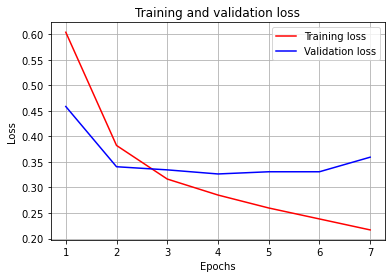

In [65]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [66]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)


In [68]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/naver_movie_review/sentimental_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim을 사용해서 학습시킨 word2vector를 사용해서 대박이라는 단어와 연관성이 있는 단어들을 뽑아보았다.
영화리뷰라고 생각해보았을 때, 긍정적인 평가들이 나오는 것을 확인할 수 있다.

In [69]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['대박']
# vector

In [70]:
word_vectors.similar_by_word("대박")

[('각지', 0.5276776552200317),
 ('싯', 0.5271451473236084),
 ('진진', 0.5242579579353333),
 ('최상', 0.5201584696769714),
 ('웰메이드', 0.5146491527557373),
 ('아름다워요', 0.5137757062911987),
 ('최고', 0.5131483674049377),
 ('수준급', 0.5086012482643127),
 ('乃', 0.5080664157867432),
 ('유머러스', 0.5069366693496704)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

pre-trained word vectors
- 한국어를 다운로드
- 위키피디아를 통해서 만든 Word2Vec를 만든 것 같다.

In [71]:
import os

In [72]:
os.listdir('sentimental_classification/')

['word2vec.txt',
 'ratings_test.txt',
 'GoogleNews-vectors-negative300.bin',
 'GoogleNews-vectors-negative300.bin.gz',
 'ko.tsv',
 'ko.bin',
 'ratings_train.txt']

In [73]:
os.getenv('HOME')+'/aiffel/naver_movie_review/sentimental_classification/ko.tsv'

'/home/aiffel0042/aiffel/naver_movie_review/sentimental_classification/ko.tsv'

In [74]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/naver_movie_review/sentimental_classification/ko.bin'

In [75]:
# from gensim.models.keyedvectors import Word2VecKeyedVectors
# word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [76]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_file_path)

In [77]:
vector = word2vec['대박']
vector

array([ 0.12250227, -0.26166117,  0.1601894 ,  0.24988233, -0.19694664,
        0.20742898,  0.23358916, -0.08032743,  0.07419734,  0.28976992,
        0.05920417, -0.24217431,  0.42650384,  0.37083197,  0.01488842,
       -0.15399031,  0.21594983,  0.16782928,  0.04716487, -0.3933347 ,
        0.06105555, -0.13588727, -0.0257909 , -0.06074918,  0.04168789,
        0.34588724,  0.24693313, -0.05122459,  0.16371667,  0.05747311,
       -0.12627307, -0.16464052, -0.29741055,  0.17121391, -0.24180788,
       -0.28056645, -0.06616814,  0.15681611,  0.20206362, -0.1660444 ,
        0.00203782, -0.2563252 , -0.24074501, -0.63730514,  0.35244125,
        0.05436644, -0.14913762, -0.06556495, -0.05610788,  0.11254067,
       -0.09251513, -0.28059378,  0.07197419,  0.11595767,  0.15117767,
       -0.00541334, -0.128903  ,  0.04034068, -0.22690742,  0.00775241,
        0.16708778,  0.10937496, -0.17221814,  0.04758313,  0.321897  ,
        0.0646909 ,  0.292136  , -0.07984147,  0.09785581,  0.18

In [78]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

위에서 만든 임베딩을 여기서 학습하는데 활용한다.
모델은 위에서 사용한것과 동일하게 LSTM을 사용하였고 LSTM 레이어의 차원도 128로 설정하였다.
여기서 Embedding 레이어에 embedding_matrix로 초기화를 해주었기 때문에 word_vector_dim과 같은 경우는 기존에 초기화 되어있는 임베딩의 차원인 200으로 줘야한다.

In [79]:
from keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [80]:
# 학습의 진행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
984/986 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.5683
Epoch 00001: val_accuracy did not improve from 0.86250
986/986 [==============================] - 17s 17ms/step - loss: 0.6671 - accuracy: 0.5687 - val_loss: 0.4942 - val_accuracy: 0.7717
Epoch 2/20
984/986 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8291
Epoch 00002: val_accuracy did not improve from 0.86250
986/986 [==============================] - 17s 17ms/step - loss: 0.3835 - accuracy: 0.8292 - val_loss: 0.3346 - val_accuracy: 0.8557
Epoch 3/20
984/986 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.8709
Epoch 00003: val_accuracy improved from 0.86250 to 0.86490, saving model to model.h5
986/986 [==============================] - 18s 19ms/step - loss: 0.3014 - accuracy: 0.8710 - val_loss: 0.3141 - val_accuracy: 0.8649
Epoch 4/20
986/986 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.8903
Epoch 00004: val_accur

In [81]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3370 - accuracy: 0.8596
[0.33697712421417236, 0.8596334457397461]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


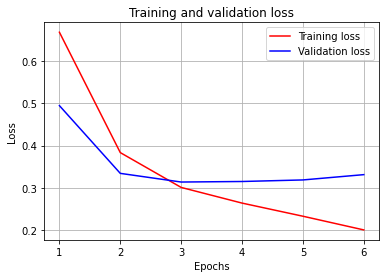

In [82]:
history_dict = history.history
print(history_dict.keys())

# 시각화를 시도한다.
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 프로젝트 제출

### 프로젝트 루브릭 : 아래의 기준을 바탕으로 프로젝트를 평가합니다.

### 평가문항 : 상세기준

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
: 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
: gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
: 네이버 영화리뷰 데이터 감성분석 정확도를 90% 이상 달성함


### 정리
- 세가지의 모델을 사용해보았다.
1. 1D CNN : 0.8413
2. LSTM : 0.8424
3. GlobalMaxPooling1D : 0.8402
- 그 중에서 제일 좋은 LSTM으로 선택, 모델구조 찾기
    - 하이퍼파라미터를 튜닝하기 전에 모델구조에 대해서 생각해 보았다.
1. CNN 1D -> LSTM
2. LSTM -> LSTM
3. LSTM 단일 레이어
    - 하지만 CNN을 추가한 경우 생각보다 점수가 낮게 나오고 LSTM 레이어를 두개를 사용해도 성능은 나아지지 않았다.
- 하이퍼파라미터 설정
    - word_vector_dim = 1000
    - LSTM 레이어의 차원 수 = 128, dropout = 0.7 적용
    - Adam optimizer의 learning rate = 0.0005
    - batch_size = 128
- Callback 함수 사용
    - EearlyStopping
    - Checkpoint
- 정확도는 0.8413 -> 0.86 으로 약 2퍼센트 성능 향상